In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import argparse
import torch.nn.functional as F
import math
from typing import List, Tuple, Union
import warnings
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
          ):

        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim,
                out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class ConvKAN(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int or tuple = 3,
        stride: int or tuple = 1,
        padding: int or tuple = 0,
        dilation: int or tuple = 1,
        groups: int = 1,
        padding_mode: str = "zeros",
        bias: bool = True,
        grid_size: int = 5,
        spline_order: int = 3,
        scale_noise: float = 0.1,
        scale_base: float = 1.0,
        scale_spline: float = 1.0,
        enable_standalone_scale_spline: bool = True,
        base_activation: torch.nn.Module = torch.nn.SiLU,
        grid_eps: float = 0.02,
        grid_range: tuple = (-1, 1),
    ):
        """
        Convolutional layer with KAN kernels. A drop-in replacement for torch.nn.Conv2d.

        Args:
            in_channels (int): Number of channels in the input image
            out_channels (int): Number of channels produced by the convolution
            kernel_size (int or tuple): Size of the convolving kernel. Default: 3
            stride (int or tuple): Stride of the convolution. Default: 1
            padding (int or tuple): Padding added to both sides of the input. Default: 0
            dilation (int or tuple): Spacing between kernel elements. Default: 1
            groups (int): Number of blocked connections from input channels to output channels. Default: 1
            padding_mode (str): Padding mode. Default: 'zeros'
            bias (bool): Added for compatibility with torch.nn.Conv2d and does make any effect. Default: True
            grid_size (int): Number of grid points for the spline. Default: 5
            spline_order (int): Order of the spline. Default: 3
            scale_noise (float): Scale of the noise. Default: 0.1
            scale_base (float): Scale of the base. Default: 1.0
            scale_spline (float): Scale of the spline. Default: 1.0
            enable_standalone_scale_spline (bool): Enable standalone scale for the spline. Default: True
            base_activation (torch.nn.Module): Activation function for the base. Default: torch.nn.SiLU
            grid_eps (float): Epsilon for the grid
            grid_range (tuple): Range of the grid. Default: (-1, 1).
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.padding_mode = padding_mode

        self._in_dim = (
            (in_channels // groups) * self.kernel_size[0] * self.kernel_size[1]
        )
        self._reversed_padding_repeated_twice = tuple(
            x for x in reversed(self.padding) for _ in range(2)
        )

        if not bias:
            # warn the user that bias is not used
            warnings.warn("Bias is not used in ConvKAN layer", UserWarning)

        if in_channels % groups != 0:
            raise ValueError("in_channels must be divisible by groups")
        if out_channels % groups != 0:
            raise ValueError("out_channels must be divisible by groups")

        self.kan_layer = FastKANLayer(self._in_dim, out_channels)

    def forward(self, x):
        if self.padding_mode != "zeros":
            x = F.pad(x, self._reversed_padding_repeated_twice, mode=self.padding_mode)
            padding = (0, 0)  # Reset padding because we already applied it
        else:
            padding = self.padding

        x_unf = F.unfold(
            x,
            kernel_size=self.kernel_size,
            padding=padding,
            stride=self.stride,
            dilation=self.dilation,
        )

        batch_size, channels_and_elem, n_patches = x_unf.shape

        # Ensuring group separation is maintained in the input
        x_unf = (
            x_unf.permute(0, 2, 1)  # [B, H_out * W_out, channels * elems]
            .reshape(
                batch_size * n_patches, self.groups, channels_and_elem // self.groups
            )  # [B * H_out * W_out, groups, out_channels // groups]
            .permute(1, 0, 2)
        )  # [groups, B * H_out * W_out, out_channels // groups]

        output = self.kan_layer(
            x_unf
        )  # [groups, B * H_out * W_out, out_channels // groups]
        output = (
            output.permute(1, 0, 2).reshape(batch_size, n_patches, -1).permute(0, 2, 1)
        )

        # Compute output dimensions
        output_height = (
            x.shape[2]
            + 2 * padding[0]
            - self.dilation[0] * (self.kernel_size[0] - 1)
            - 1
        ) // self.stride[0] + 1
        output_width = (
            x.shape[3]
            + 2 * padding[1]
            - self.dilation[1] * (self.kernel_size[1] - 1)
            - 1
        ) // self.stride[1] + 1

        # Reshape output to the expected output format
        output = output.view(
            x.shape[0],  # batch size
            self.out_channels,  # total output channels
            output_height,
            output_width,
        )

        return output


def _pair(x):
    if isinstance(x, (int, float)):
        return x, x
    return x

    
class BSplineFunction(nn.Module):
    def __init__(self, grid_min: float = -2.,
        grid_max: float = 2., degree: int = 3, num_basis: int = 8):
        super(BSplineFunction, self).__init__()
        self.degree = degree
        self.num_basis = num_basis
        self.knots = torch.linspace(grid_min, grid_max, num_basis + degree + 1)  # Uniform knots

    def basis_function(self, i, k, t):
        if k == 0:
            return ((self.knots[i] <= t) & (t < self.knots[i + 1])).float()
        else:
            left_num = (t - self.knots[i]) * self.basis_function(i, k - 1, t)
            left_den = self.knots[i + k] - self.knots[i]
            left = left_num / left_den if left_den != 0 else 0

            right_num = (self.knots[i + k + 1] - t) * self.basis_function(i + 1, k - 1, t)
            right_den = self.knots[i + k + 1] - self.knots[i + 1]
            right = right_num / right_den if right_den != 0 else 0

            return left + right 
    
    def forward(self, x):
        x = x.squeeze()  # Assuming x is of shape (B, 1)
        basis_functions = torch.stack([self.basis_function(i, self.degree, x) for i in range(self.num_basis)], dim=-1)
        return basis_functions
    
class SplineConv2D(nn.Conv2d):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 init_scale: float = 0.1, 
                 padding_mode: str = "zeros", 
                 **kw
                 ) -> None:
        self.init_scale = init_scale
        super().__init__(in_channels, 
                         out_channels, 
                         kernel_size, 
                         stride, 
                         padding, 
                         dilation, 
                         groups, 
                         bias, 
                         padding_mode, 
                         **kw
                         )

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)


class FastKANConvLayer(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 grid_min: float = -2., 
                 grid_max: float = 2.,
                 num_grids: int = 4, 
                 use_base_update: bool = True, 
                 base_activation = F.silu,
                 spline_weight_init_scale: float = 0.1, 
                 padding_mode: str = "zeros",
                 ) -> None:
        
        super().__init__()
        self.rbf = BSplineFunction(grid_min, grid_max, 3, num_grids)

        self.spline_conv = SplineConv2D(in_channels * num_grids, 
                                        out_channels, 
                                        kernel_size,
                                        stride, 
                                        padding, 
                                        dilation, 
                                        groups, 
                                        bias,
                                        spline_weight_init_scale, 
                                        padding_mode)
        
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_conv = nn.Conv2d(in_channels, 
                                       out_channels, 
                                       kernel_size, 
                                       stride, 
                                       padding, 
                                       dilation, 
                                       groups, 
                                       bias, 
                                       padding_mode)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x_rbf = self.rbf(x.view(batch_size, channels, -1)).view(batch_size, channels, height, width, -1)
        x_rbf = x_rbf.permute(0, 4, 1, 2, 3).contiguous().view(batch_size, -1, height, width)
        
        # Apply spline convolution
        ret = self.spline_conv(x_rbf)
        
        if self.use_base_update:
            base = self.base_conv(self.base_activation(x))
            ret = ret + base
        
        return ret


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResEmoteNetKAN(nn.Module):
    def __init__(self):
        super(ResEmoteNetKAN, self).__init__()
        self.conv1 = ConvKAN(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = FastKANConvLayer(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = FastKANConvLayer(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)

        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.kan1 = FastKANLayer(2048, 1024)
        self.kan2 = FastKANLayer(1024, 512)
        self.kan3 = FastKANLayer(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.kan4 = FastKANLayer(256, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.kan1(x))
        x = self.dropout2(x)
        x = F.relu(self.kan2(x))
        x = self.dropout2(x)
        x = F.relu(self.kan3(x))
        x = self.dropout2(x)
        x = self.kan4(x)
        return x



In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNetKAN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetCNN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:13<00:00, 33.63it/s]



Epoch 1:
Train Loss: 2.1087, Train Acc: 0.1979
Val Loss: 1.8557, Val Acc: 0.2471


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.62it/s]



Epoch 2:
Train Loss: 1.9436, Train Acc: 0.2131
Val Loss: 1.8888, Val Acc: 0.1737
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 37.41it/s]



Epoch 3:
Train Loss: 1.8576, Train Acc: 0.2197
Val Loss: 1.8225, Val Acc: 0.2471
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.87it/s]



Epoch 4:
Train Loss: 4.1753, Train Acc: 0.2194
Val Loss: 1.8363, Val Acc: 0.2471
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.36it/s]



Epoch 5:
Train Loss: 3.6024, Train Acc: 0.2164
Val Loss: 1.8412, Val Acc: 0.2471
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.79it/s]



Epoch 6:
Train Loss: 1.8539, Train Acc: 0.2205
Val Loss: 1.8713, Val Acc: 0.2471
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 37.17it/s]



Epoch 7:
Train Loss: 3.2807, Train Acc: 0.2154
Val Loss: 1.8571, Val Acc: 0.1718
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 37.35it/s]



Epoch 8:
Train Loss: 1.8570, Train Acc: 0.2193
Val Loss: 1.8394, Val Acc: 0.2471
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.74it/s]



Epoch 9:
Train Loss: 1.8533, Train Acc: 0.2182
Val Loss: 1.8277, Val Acc: 0.2471
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.94it/s]



Epoch 10:
Train Loss: 1.8548, Train Acc: 0.2221
Val Loss: 1.8450, Val Acc: 0.2471
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 38.12it/s]



Epoch 11:
Train Loss: 1.8526, Train Acc: 0.2202
Val Loss: 1.8531, Val Acc: 0.1737
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 37.02it/s]



Epoch 12:
Train Loss: 1.8507, Train Acc: 0.2189
Val Loss: 1.8340, Val Acc: 0.2471
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.87it/s]



Epoch 13:
Train Loss: 1.8559, Train Acc: 0.2206
Val Loss: 1.8592, Val Acc: 0.1737
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 38.66it/s]



Epoch 14:
Train Loss: 1.8546, Train Acc: 0.2203
Val Loss: 1.8381, Val Acc: 0.1737
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.31it/s]



Epoch 15:
Train Loss: 1.8503, Train Acc: 0.2186
Val Loss: 1.8806, Val Acc: 0.1718
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.45it/s]


Epoch 16:
Train Loss: 1.8516, Train Acc: 0.2175
Val Loss: 1.8403, Val Acc: 0.2471
No improvement for 15 epochs.
Early stopping triggered.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result

# Example usage:
"""
# For single format conversion:
pt_path = convert_pth_to_pt('ResEmoteNetCNN_model.pth')
# or
ptl_path = convert_pth_to_ptl('ResEmoteNetCNN_model.pth')

# For converting to both formats:
pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')
"""

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.kan_layer.layernorm.weight         27
conv1.kan_layer.layernorm.bias         27
conv1.kan_layer.spline_linear.weight     13,824
conv1.kan_layer.base_linear.weight      1,728
conv1.kan_layer.base_linear.bias         64
bn1.weight                             64
bn1.bias                               64
conv2.spline_conv.weight          294,912
conv2.spline_conv.bias                128
conv2.base_conv.weight             73,728
conv2.base_conv.bias                  128
bn2.weight                            128
bn2.bias                              128
conv3.spline_conv.weight        1,179,648
conv3.spline_conv.bias                256
conv3.base_conv.weight            294,912
conv3.base_conv.bias                  256
bn3.weight                            256
bn3.bias                              256
se.fc.0.weight                      4,096
se.fc.2.weight                      4,096
res_block1.conv1.weight    

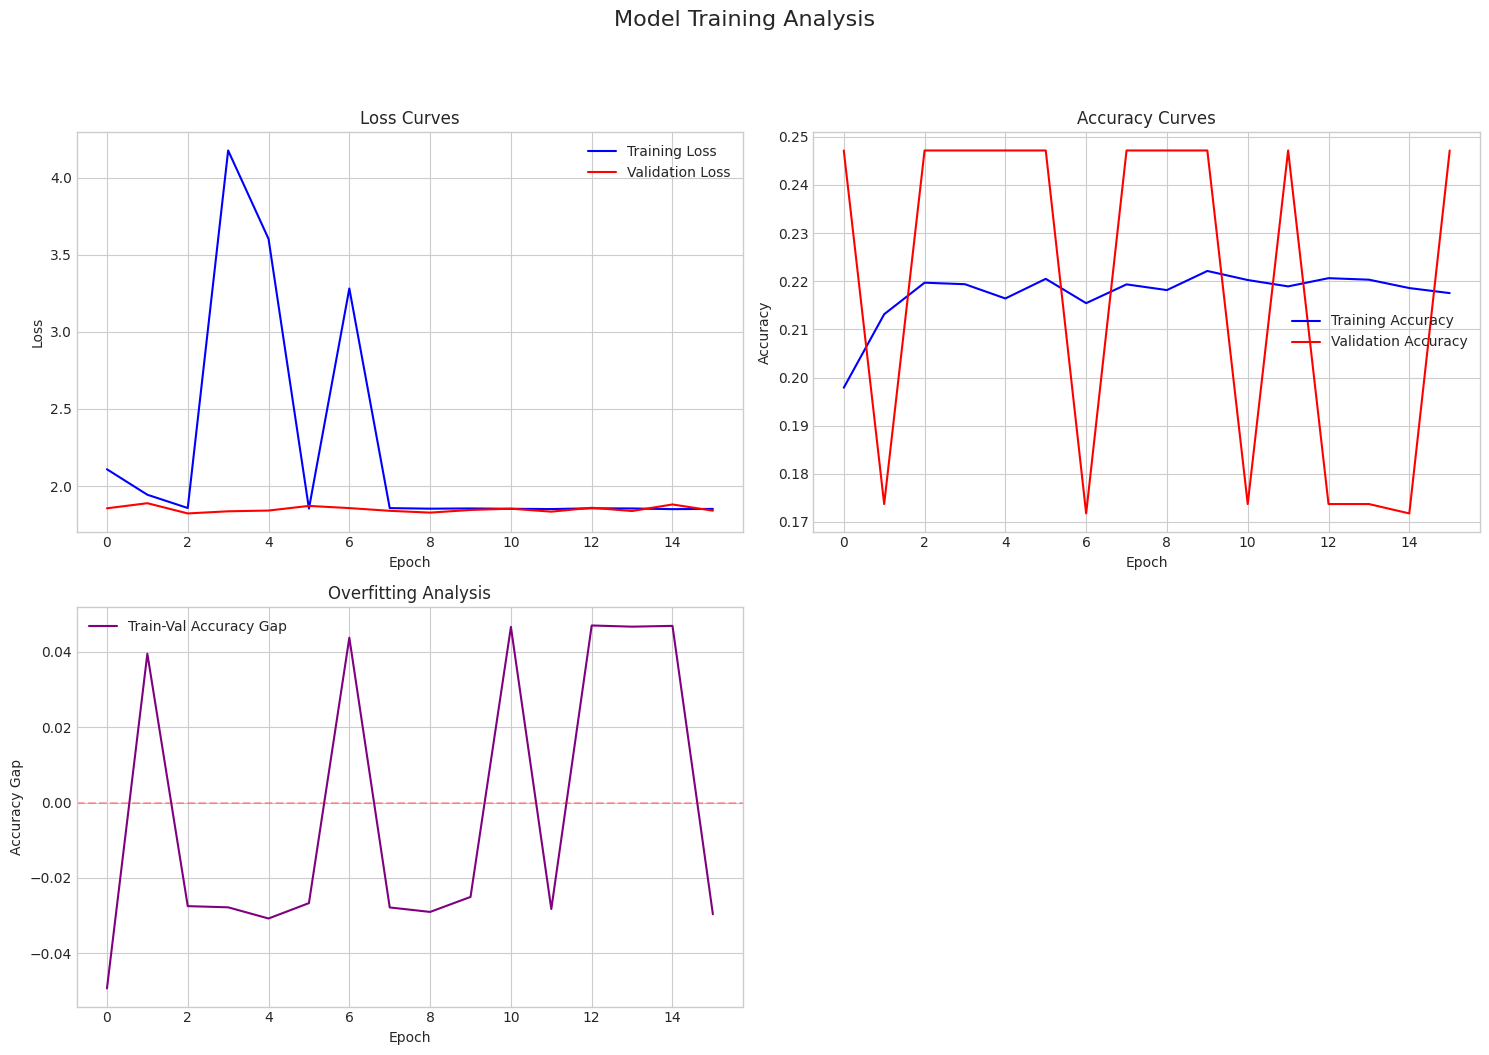

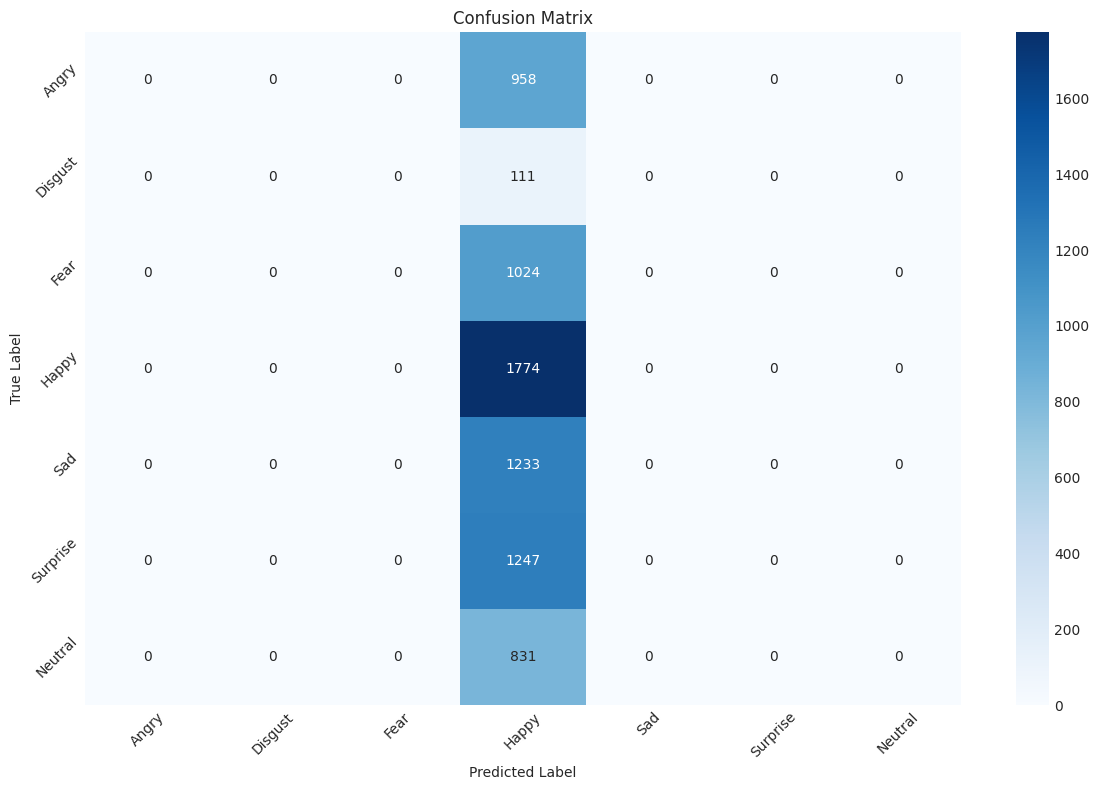


Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.00      0.00      0.00      1024
       Happy       0.25      1.00      0.40      1774
         Sad       0.00      0.00      0.00      1233
    Surprise       0.00      0.00      0.00      1247
     Neutral       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



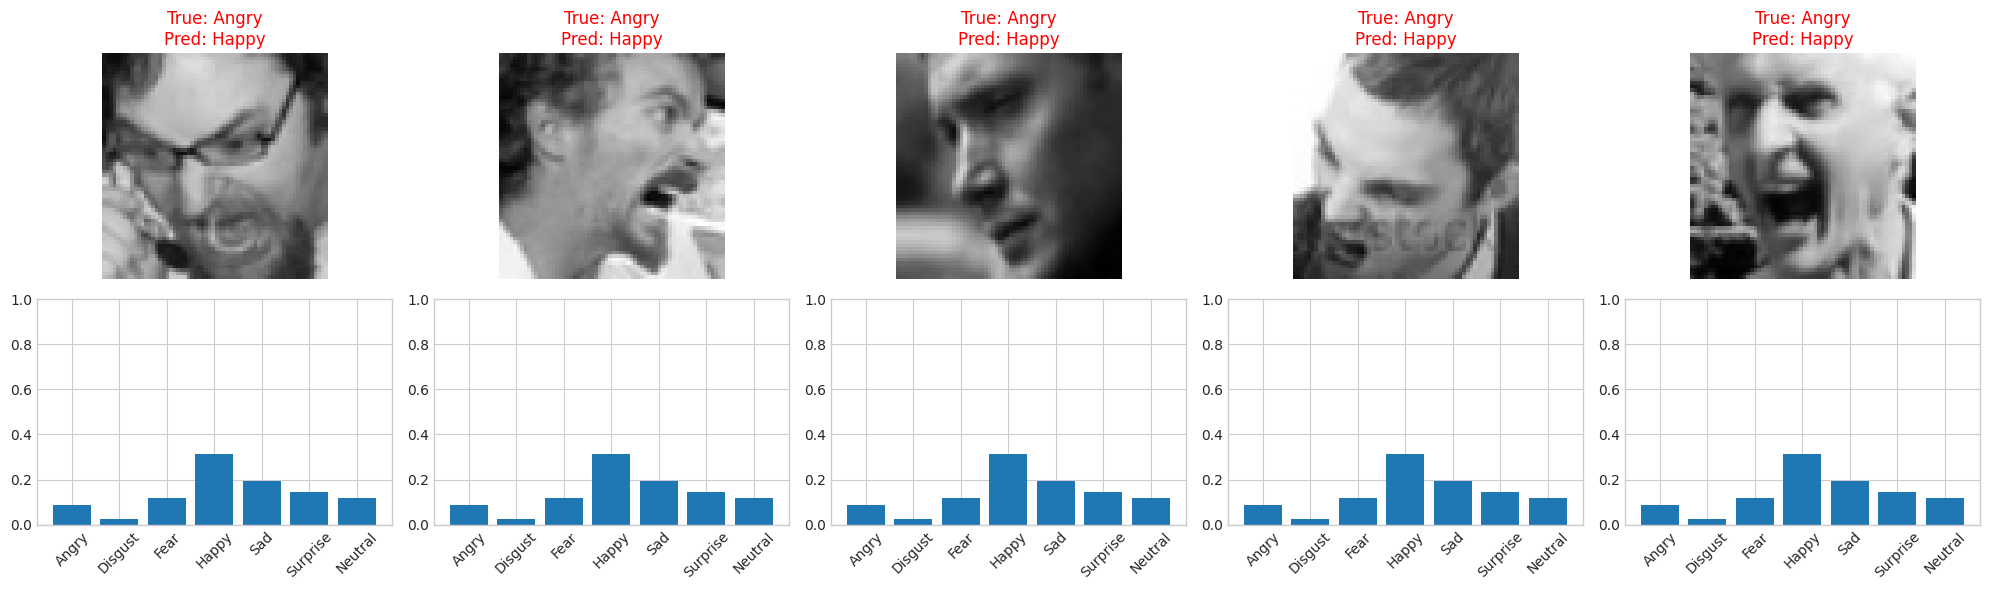

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)